In [1]:
import  pandas as pd 
import numpy as np 
import os 
os.chdir("../")

In [2]:
### Load in the data 
df = pd.read_csv("data/aggregated.csv")
df = df.drop(columns=["Unnamed: 13"])
df = df.dropna()
df.head()

,MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,FL_NUM,ORIGIN,ORIGIN_CITY_NAME,DEST,DEST_CITY_NAME,CRS_DEP_TIME,ARR_DEL15,CRS_ELAPSED_TIME,DISTANCE
0,2.0,6.0,2017-02-25,B6,28.0,MCO,"Orlando, FL",EWR,"Newark, NJ",1000.0,0.0,156.0,937.0
1,2.0,7.0,2017-02-26,B6,28.0,MCO,"Orlando, FL",EWR,"Newark, NJ",739.0,0.0,153.0,937.0
2,2.0,1.0,2017-02-27,B6,28.0,MCO,"Orlando, FL",EWR,"Newark, NJ",1028.0,0.0,158.0,937.0
3,2.0,2.0,2017-02-28,B6,28.0,MCO,"Orlando, FL",EWR,"Newark, NJ",739.0,0.0,153.0,937.0
4,2.0,3.0,2017-02-01,B6,33.0,BTV,"Burlington, VT",JFK,"New York, NY",1907.0,0.0,90.0,266.0


array([[<AxesSubplot:xlabel='MONTH', ylabel='MONTH'>,
        <AxesSubplot:xlabel='DAY_OF_WEEK', ylabel='MONTH'>,
        <AxesSubplot:xlabel='FL_NUM', ylabel='MONTH'>,
        <AxesSubplot:xlabel='CRS_DEP_TIME', ylabel='MONTH'>,
        <AxesSubplot:xlabel='ARR_DEL15', ylabel='MONTH'>,
        <AxesSubplot:xlabel='CRS_ELAPSED_TIME', ylabel='MONTH'>,
        <AxesSubplot:xlabel='DISTANCE', ylabel='MONTH'>],
       [<AxesSubplot:xlabel='MONTH', ylabel='DAY_OF_WEEK'>,
        <AxesSubplot:xlabel='DAY_OF_WEEK', ylabel='DAY_OF_WEEK'>,
        <AxesSubplot:xlabel='FL_NUM', ylabel='DAY_OF_WEEK'>,
        <AxesSubplot:xlabel='CRS_DEP_TIME', ylabel='DAY_OF_WEEK'>,
        <AxesSubplot:xlabel='ARR_DEL15', ylabel='DAY_OF_WEEK'>,
        <AxesSubplot:xlabel='CRS_ELAPSED_TIME', ylabel='DAY_OF_WEEK'>,
        <AxesSubplot:xlabel='DISTANCE', ylabel='DAY_OF_WEEK'>],
       [<AxesSubplot:xlabel='MONTH', ylabel='FL_NUM'>,
        <AxesSubplot:xlabel='DAY_OF_WEEK', ylabel='FL_NUM'>,
        <AxesSubplot

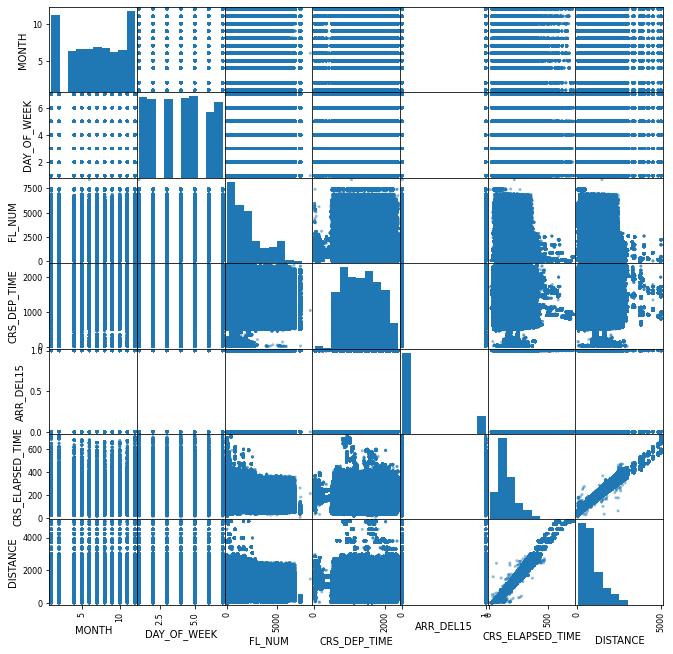

In [10]:
## Lets explore the data starting with a scatter matrix 
from pandas.plotting import scatter_matrix
%matplotlib inline
scatter_matrix(df, figsize=(11,11))

## Observations
### From this scatter plot analysis, we see the only values that are linearly coordinated appear to be ELAPSED_TIME x DISTANCE... intuitively this makes perfect sense as the distance a plane has to travel increases, the amount of time it takes to reach destination should increase as well
### ARR_DEL15 appears to not be conditionally based upon any one of the other individual features.. maybe a model that doesn't assume linear relationships would work well
### MONTH and DAY_OF_WEEK have what appear to be categorical relationships, however they should insetad cyclical or represented in some form like a circular array 

In [4]:
from matplotlib import pyplot as plt 

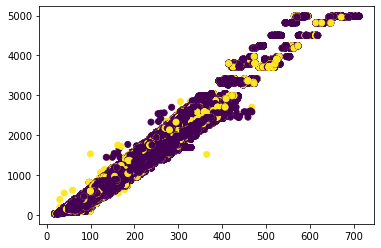

In [13]:
plt.scatter(x=df['CRS_ELAPSED_TIME'], y=df['DISTANCE'], c=df['ARR_DEL15'])

In [5]:
df['FL_DATE'].value_counts()

2016-11-27    16948
2016-08-05    16917
2016-07-11    16827
2016-08-04    16821
2016-07-15    16814
              ...  
2016-12-03    11495
2016-12-10    11363
2017-01-14    11337
2017-01-07    10531
2016-11-24     9784
Name: FL_DATE, Length: 334, dtype: int64

In [39]:
from scripts.preprocessing import  get_delayed_not_delayed_counts

delayed, not_delayed = get_delayed_not_delayed_counts(df["FL_DATE"], df["ARR_DEL15"])
    

In [7]:
print("Day with delay count -> ", len(delayed))
print("Total days ->", len(df['FL_DATE'].value_counts()))
print("Proportionality of delayed days ->", len(delayed) / len(df['FL_DATE'].value_counts()))
print("Day without delay count -> ", len(not_delayed))
print("Total days ->", len(df['FL_DATE'].value_counts()))
print("Proportionality of delayed days ->", len(not_delayed) / len(df['FL_DATE'].value_counts()))


Day with delay count ->  334
Total days -> 334
Proportionality of delayed days -> 1.0
Day without delay count ->  334
Total days -> 334
Proportionality of delayed days -> 1.0


#### the FL_DATE column doesn't seem to be too indicative of anything really since every single one of its unique values shares rows with and without a delayed flight, therefore it won't be too useful in determining if a flight is going to be delayed and should be dropped... although an useful feature could potentially be extracted from this column if the right transformation is applied 

In [20]:
from numpy import std
std_dev = std(np.array(list(delayed.values())))
print("std dev ->", std_dev)
mean_delays = sum(delayed.values())/len(delayed)
print("mean ->", mean_delays)

std dev -> 1154.7228889082112
mean -> 2727.75748502994


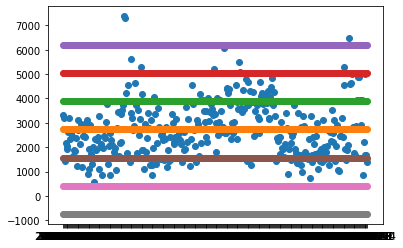

In [23]:
plt.scatter(x=delayed.keys(), y=delayed.values())
plt.scatter(x=delayed.keys(), y=[mean_delays]*len(delayed.keys()) )
# 1 stdv
plt.scatter(x=delayed.keys(), y=[mean_delays+std_dev]*len(delayed.keys()))
# 2 stdv
plt.scatter(x=delayed.keys(), y=[mean_delays+2 * std_dev]*len(delayed.keys()))
# 3 stdv
plt.scatter(x=delayed.keys(), y=[mean_delays+ 3 * std_dev]*len(delayed.keys()))
plt.scatter(x=delayed.keys(), y=[mean_delays-std_dev]*len(delayed.keys()))
plt.scatter(x=delayed.keys(), y=[mean_delays - 2*std_dev]*len(delayed.keys()))
plt.scatter(x=delayed.keys(), y=[mean_delays- 3*std_dev]*len(delayed.keys()))


### After plotting the mean and +-(3) stdevs from it, we see that the dates with the highest count of flight delays occur greater than 3stdvs with no data points in the lower range bounded values... Most of the data points completely converge between 1 and -1 std deviations

In [52]:
## Lets see the days with the most delayed flights and try to inference why  
sorted_delays = sorted(delayed.items(), key=lambda x: x[1], reverse=True)


In [53]:
import json
### Let's write value counts a file for safe keepings
with open("busiest_days_asc.json", "w") as fw:
    json.dump([e for e in df['FL_DATE'].value_counts()], fw)

#### Hmmmm, The week before christmas appeared to have the highest count delayed, lets do some geographical tranformations and generate some maps showing were concentration is the highest

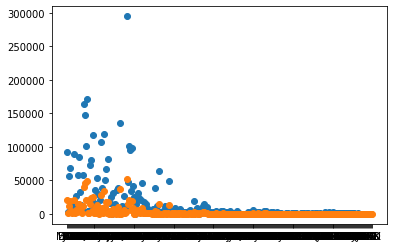

In [37]:
from matplotlib import pyplot as plt  
## These irrelevant 
delayed, not_delayed = get_delayed_not_delayed_counts(df["ORIGIN"], df["ARR_DEL15"])
plt.scatter(x=not_delayed.keys(), y=not_delayed.values())
plt.scatter(x=delayed.keys(), y=delayed.values())


## Graph Observations 
### From this graph, its become apparent that days with higher delays are also days with a high number of flights...
### Maybe some feature extracted from FL_DATE to indicate if the day is a busy day could be helpful in improving accuracy

In [31]:
sorted_delays = sorted(delayed.items(), key=lambda x: x[1], reverse=True)
sorted_no_delays = sorted(not_delayed.items(), key=lambda x: x[1], reverse=True)
dest_delayed, dest_not_delayed = get_delayed_not_delayed_counts(df["ORIGIN"], df["ARR_DEL15"])

sorted_origin_keys = [e[0] for e in sorted_delays]
sorted_origin_no_keys = [e[0] for e in sorted_no_delays]

dest_delayed = sorted(dest_delayed.items(), key=lambda x: x[1], reverse=True)
dest_not_delayed = sorted(dest_not_delayed.items(), key=lambda x: x[1], reverse=True)
sorted_dest_keys = [e[0] for e in dest_delayed]
sorted_dest_not_keys = [e[0] for e in dest_not_delayed]


### Hmmm, the SPN value seems to exist for ORIGIN but not for DEST, a function should be written to remove that single column value from the DF as a whole since it's only seen for one and we want to ensure ORIGIN and DEST remain represented as a bipartisan graph with links going both ways

,ORIGIN_DELAYED_SORT,ORIGIN_NON_DELAYED_SORT,DEST_DELAYED_SORTED,DEST_NON_DELAYED_SORTED
0,ATL,ATL,ATL,ATL
1,ORD,ORD,ORD,ORD
2,LAX,DEN,LAX,DEN
3,DEN,LAX,DEN,LAX
4,DFW,DFW,DFW,DFW
5,SFO,SFO,SFO,SFO
6,LAS,PHX,LAS,PHX
7,PHX,LAS,PHX,LAS
8,EWR,SEA,EWR,SEA
9,BOS,IAH,BOS,IAH


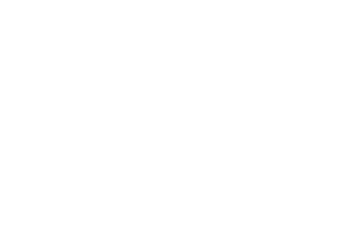

In [38]:
fig, ax = plt.subplots()

# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

temp_df = pd.DataFrame(zip(sorted_origin_keys[0 : 50], sorted_origin_no_keys[0:50], sorted_dest_keys[0:50], sorted_dest_not_keys[0:50]), columns=["ORIGIN_DELAYED_SORT", "ORIGIN_NON_DELAYED_SORT", "DEST_DELAYED_SORTED", "DEST_NON_DELAYED_SORTED"])

temp_df.head(40)

## Model selection
### The problem is predicting the binary output of whether or not a flight is delayed, this appears to be a supervised learning classification task 
### The data itself doesn't seem to have many linear relationships at all, making the use of different regression algorithms like linear, polynomial, and logistic regression rather infeasable due to their innate programatic nature of assuming linearity 
### A decision tree based algorithm seems very appropiate for this data set, however a single decision tree wouldn't be able to correctly classify the 512 million rows with high accuracy.. instead a random forest classifier seems like the best fit due to it's utulization of multiple decision trees and separation of concern amongst features

## Metric Selection 
### For most important metric, I'm going to assume FL_DATE, even as counter intuitive as that might sound... the reasons being it can be a metric used for further feature extraction since their appeared to be a cluster within the data for the highest number of delays being upon certain days of the year with a majority of flight delays falling upon just 40 days out of the year    